In [1]:

from tqdm import tqdm

from embeddings.embedding_utils import get_queries, get_query_key
import pickle
import numpy as np
import pandas as pd
import math
from collections import Counter

In [2]:
def load_clustering(query_key, embedding_algo, clustering_algo):
    embedding_algo_name=embedding_algo.__module__.split(".")[-1]+"__"+embedding_algo.__name__
    clustering_algo_name=clustering_algo.__name__
    filename = f"../cluster_results/{embedding_algo_name}/{clustering_algo_name}/{query_key}.pkl"
    with open(filename, "rb") as f:
        data_dict = pickle.load(f)
    return np.array(data_dict["embeddings"]),np.array(data_dict["clusters"]), pd.Series(data_dict["numerical_labels_true"]), data_dict["categorizer"]

def load_original_document(query_key):
    filename = f"../query_results/{query_key}.pkl"
    with open(filename, "rb") as f:
        data_dict = pickle.load(f)
    return data_dict["data"]

In [3]:
def remove_noise_entries(numerical_label_lists, assigned_labels):
    no_noise_indices= np.array(assigned_labels) != -1
    return numerical_label_lists[no_noise_indices], np.array(assigned_labels)[no_noise_indices]

def make_noise_cluster(assigned_labels):
    noise_indices= np.array(assigned_labels) == -1
    free_cluster_label = len(set(assigned_labels))
    new_labels = np.array(assigned_labels)
    new_labels[noise_indices] = free_cluster_label
    return new_labels

In [4]:
def get_idf(numerical_labels_lists):
    flatlist= [item for sublist in numerical_labels_lists for item in sublist]
    counter = Counter(flatlist)
    idf = {
        key:math.log2(len(numerical_labels_lists)/value) for key, value in counter.items()
    }
    return idf

In [5]:
def simJ_similar(idf_dict, labels_1, labels_2):
    threshold=0.25
    intersection = set(labels_1).intersection(labels_2)
    union = set(labels_1).union(labels_2)
    score = sum([idf_dict[lab] for lab in intersection])/sum([idf_dict[lab] for lab in union])
    return score>threshold

In [6]:
def get_pair_confusion_matrix(idf_dict, clustering_labels, numerical_labels_true):
    TP=0
    FP=0
    TN=0
    FN=0
    for i, (cluster_label_1, member_1) in enumerate(zip(clustering_labels, numerical_labels_true)):
        for cluster_label_2, member_2 in zip(clustering_labels[i+1:], numerical_labels_true[i+1:]):
            if cluster_label_1 == cluster_label_2:
                if simJ_similar(idf_dict, member_1, member_2):
                    TP +=1
                else:
                    FP+=1
            else:
                if simJ_similar(idf_dict, member_1, member_2):
                    FN +=1
                else:
                    TN+=1
    return np.array([[TP, FP],
                     [FN, TN]])


In [7]:
from embeddings.tf_idf import get_embedding_pca as tf_idf_pca
from embeddings.fasttext import get_embedding_combined_polling_pca
from embeddings.openai_api import get_embedding as embedding_openai

from clustering.clusterings import kmeans_with_estimated_k,xmeans_clustering, hdbscan_clustering, agglomerative_clustering_with_estimated_k

data_queries = get_queries()
embedding_algos = [tf_idf_pca,get_embedding_combined_polling_pca, embedding_openai]
clustering_algos = [kmeans_with_estimated_k,xmeans_clustering, agglomerative_clustering_with_estimated_k]
clustering_algos_noise = [hdbscan_clustering]

In [8]:
pair_confusion_matrices = np.zeros((4,5,len(embedding_algos),len(clustering_algos)+2*len(clustering_algos_noise),2,2))

string_to_num_translator = {}
num_to_string_translator = {}
for i_0, category in tqdm(enumerate(data_queries.keys()),desc="Categories"):
    string_to_num_translator["0:"+category] = i_0
    num_to_string_translator["0:" + str(i_0)] = category
    for i_1, query in tqdm(enumerate(data_queries[category]),desc="Queries", leave=False):
        string_to_num_translator["1:"+query] = i_1
        num_to_string_translator["1:" + str(i_1)] = query
        query_key = get_query_key(category, query)

        doc_set_label_idf = None

        for i_2, embedding_algo in tqdm(enumerate(embedding_algos),desc="Embeddings",leave=False):
            embedding_algo_name = embedding_algo.__module__.split(".")[-1] + "__" + embedding_algo.__name__
            string_to_num_translator["2:"+embedding_algo_name] = i_2
            num_to_string_translator["2:"+str(i_2)] = embedding_algo_name

            for i_3, cluster_algo in enumerate(clustering_algos):
                cluster_algo_name = cluster_algo.__name__
                string_to_num_translator["3:"+cluster_algo_name] = i_3
                num_to_string_translator["3:"+str(i_3)] = cluster_algo_name
                embedding, cluster_labels, numerical_labels_true, _ = load_clustering(query_key, embedding_algo, cluster_algo)

                #fresh idf
                doc_set_label_idf = get_idf(numerical_labels_true)

                conf_matr = get_pair_confusion_matrix(doc_set_label_idf, cluster_labels, numerical_labels_true)
                pair_confusion_matrices[i_0,i_1,i_2,i_3,:,:] = conf_matr

            for i_3, cluster_algo in enumerate(clustering_algos_noise):
                i_3 = 2 * i_3 + len(clustering_algos)
                cluster_algo_name = cluster_algo.__name__+" no noise"
                string_to_num_translator["3:"+cluster_algo_name] = i_3
                num_to_string_translator["3:"+str(i_3)] = cluster_algo_name

                embedding, cluster_labels, numerical_labels_true, _ = load_clustering(query_key, embedding_algo, cluster_algo)
                numerical_labels_true_no_noise, labels_no_noise= remove_noise_entries(numerical_labels_true, cluster_labels)

                #fresh idf
                doc_set_label_idf = get_idf(numerical_labels_true_no_noise)
                conf_matr = get_pair_confusion_matrix(doc_set_label_idf, labels_no_noise, numerical_labels_true_no_noise)
                pair_confusion_matrices[i_0,i_1,i_2,i_3,:,:] = conf_matr

                i_3+=1
                cluster_algo_name = cluster_algo.__name__+" noise-cluster"
                string_to_num_translator["3:"+cluster_algo_name] = i_3
                num_to_string_translator["3:"+str(i_3)] = cluster_algo_name

                labels_noise_cluster= make_noise_cluster(cluster_labels)

                #fresh idf
                doc_set_label_idf = get_idf(numerical_labels_true)
                conf_matr = get_pair_confusion_matrix(doc_set_label_idf, labels_noise_cluster, numerical_labels_true)
                pair_confusion_matrices[i_0,i_1,i_2,i_3,:,:] = conf_matr

Categories: 0it [00:00, ?it/s]
Queries: 0it [00:00, ?it/s]

Embeddings: 0it [00:00, ?it/s]

Embeddings: 1it [00:02,  2.09s/it]

Embeddings: 2it [00:03,  1.89s/it]

Embeddings: 3it [00:05,  1.81s/it]

                                  
Queries: 1it [00:05,  5.61s/it]

Embeddings: 0it [00:00, ?it/s]

Embeddings: 1it [00:32, 32.48s/it]

Embeddings: 2it [01:10, 35.80s/it]

Embeddings: 3it [01:42, 33.85s/it]

                                  
Queries: 2it [01:47, 62.40s/it]

Embeddings: 0it [00:00, ?it/s]

Embeddings: 1it [02:37, 157.09s/it]

Embeddings: 2it [05:09, 154.47s/it]

Embeddings: 3it [06:24, 118.18s/it]

                                   
Queries: 3it [08:12, 209.59s/it]

Embeddings: 0it [00:00, ?it/s]

Embeddings: 1it [00:00,  2.74it/s]

Embeddings: 2it [00:00,  2.61it/s]

Embeddings: 3it [00:01,  2.61it/s]

                                  
Queries: 4it [08:13, 127.30s/it]

Embeddings: 0it [00:00, ?it/s]

Embeddings: 1it [00:07,  7.34s/it]

Embeddings: 2it [00:16,  8.22s/it]

In [9]:
def data_function(category, score_type, embedding_algo_name, cluster_algo_name):
    i_0=string_to_num_translator["0:"+category]
    i_2=string_to_num_translator["2:"+embedding_algo_name]
    i_3=string_to_num_translator["3:"+cluster_algo_name]
    i_4=["Precision","Recall","F1","$\\phi$"].index(score_type)
    pres=0
    rec=0
    f1=0
    phi=0
    k1,k2,k3,k4=0,0,0,0
    for i_1 in range(5):
        matrix=pair_confusion_matrices[i_0,i_1,i_2,i_3,:,:]
        if matrix[0,0]+matrix[0,1]>0:
            pres += matrix[0,0]/(matrix[0,0]+matrix[0,1])
            k1+=1
        if matrix[0,0]+matrix[1,0]>0:
            rec += matrix[0,0]/(matrix[0,0]+matrix[1,0])
            k2 +=1
        if 2*matrix[0,0]+matrix[0,1]+matrix[1,0]>0:
            f1 += 2*matrix[0,0]/(2*matrix[0,0]+matrix[0,1]+matrix[1,0])
            k3 +=1
        if matrix[0,0]+matrix[1,1]+matrix[0,1]+matrix[1,0]>0:
            phi += (matrix[0,0]*matrix[1,1]-matrix[0,1]*matrix[1,0])/math.sqrt((matrix[0,0]+matrix[0,1])*(matrix[1,0]+matrix[1,1])*(matrix[0,0]+matrix[1,0])*(matrix[0,1]+matrix[1,1]))
            k4 +=1
    if k1>0:
        pres /= k1
    if k2>0:
        rec /= k2
    if k3>0:
        f1 /= k3
    if k4>0:
        phi /= k4
    return f"{[pres, rec, f1, phi][i_4]:.3f}"


In [10]:
# make the header of the table
column_main_labels = [embedding_algo.__module__.split(".")[-1] + "__" + embedding_algo.__name__ for embedding_algo in embedding_algos]
column_sub_labels = [cluster_algo.__name__ for cluster_algo in clustering_algos]
column_sub_labels.extend([cluster_algo.__name__+" no noise" for cluster_algo in clustering_algos_noise])
column_sub_labels.extend([cluster_algo.__name__+" noise-cluster" for cluster_algo in clustering_algos_noise])
row_main_labels = [category for category in data_queries.keys()]
row_sub_labels = ["Precision","Recall","F1","$\\phi$"]

num_col_main = len(column_main_labels)
num_col_sub = len(column_sub_labels)
num_row_main = len(row_main_labels)

In [11]:
escaped_=r"\_"
bckslsh='\\'
latex_code = r"  \begin{tabular}{|l|c|*{" + str(num_col_main * num_col_sub) + r"}{c|}}" + "\n"
latex_code += r"    \hline" + "\n"
latex_code += r"    \multicolumn{2}{|c|}{\multirow{2}{*}{}} &"
for i, main_label in enumerate(column_main_labels):
    latex_code += rf" \multicolumn{{{num_col_sub}}}{{c|}}{{{main_label}}}"
    if i < num_col_main - 1:
        latex_code += " &"
latex_code += r" \\" + "\n"
latex_code += r"    \cline{3-" + str(2 + num_col_main * num_col_sub) + "}" + "\n"
latex_code += r"    \multicolumn{2}{|c|}{} &"
for j in range(len(column_main_labels)):
    for i, sub_label in enumerate(column_sub_labels):
        latex_code += rf" \multicolumn{{1}}{{c|}}{{\rotatebox{{90}}{{{sub_label.replace('_',escaped_)}~}}}}"
        if i < len(column_sub_labels) - 1 or j < len(column_main_labels) - 1:
            latex_code += " &"
latex_code += r" \\" + "\n"
latex_code += r"    \hline" + "\n"

pres_avges=np.zeros((len(column_main_labels) * len(column_sub_labels)))
rec_avges =np.zeros((len(column_main_labels) * len(column_sub_labels)))
f1_avges= np.zeros((len(column_main_labels) * len(column_sub_labels)))
phi_avges = np.zeros((len(column_main_labels) * len(column_sub_labels)))

for i, main_label in enumerate(row_main_labels):
    num_sub_rows = len(row_sub_labels)
    latex_code += rf"    \multirow{{{num_sub_rows}}}{{*}}{{\makecell{{{main_label}}}}}"
    for j, sub_label in enumerate(row_sub_labels):
        if j==2:
            latex_code += f" & \\textbf{{{sub_label}}} &"
        else:
            latex_code += f" & {sub_label} &"
        for col_main_idx, col_main in enumerate(column_main_labels):
            for col_sub_idx, col_sub in enumerate(column_sub_labels):
                data = data_function(main_label, sub_label, col_main, col_sub)
                if j==2 or j==3:
                    latex_code += f" \\textbf{{{data.replace('0.','.')}}}"
                else:
                    latex_code += f" {data.replace('0.','.')}"
                if col_main_idx < num_col_main - 1 or col_sub_idx < len(column_sub_labels) - 1:
                    latex_code += " &"
                if j==0:
                    pres_avges[col_main_idx * len(column_sub_labels) + col_sub_idx] += float(data)
                elif j==1:
                    rec_avges[col_main_idx * len(column_sub_labels) + col_sub_idx] += float(data)
                elif j==2:
                    f1_avges[col_main_idx * len(column_sub_labels) + col_sub_idx] += float(data)
                elif j==3:
                    phi_avges[col_main_idx * len(column_sub_labels) + col_sub_idx] += float(data)

        latex_code += r" \\" + "\n"

    latex_code += r"    \hline" + "\n"
latex_code += r"    \hline" + "\n"
pres_avges /= len(row_main_labels)
rec_avges /= len(row_main_labels)
f1_avges /= len(row_main_labels)
phi_avges /= len(row_main_labels)
latex_code += rf"""\multirow{{4}}{{*}}{{\makecell{{Average}}}} & Precision & {' & '.join([f'{avg_val:.3f}'.replace('0.','.') for avg_val in pres_avges])} \\
 & Recall & {' & '.join([f'{avg_val:.3f}'.replace('0.','.') for avg_val in rec_avges])} \\
 & \textbf{{F1}} & {' & '.join([bckslsh+f'textbf{{{avg_val:.3f}}}'.replace('0.','.') for avg_val in f1_avges])} \\"""+"\n"+rf"""
 & \textbf{{$\phi$}} & {' & '.join([bckslsh+f'textbf{{{avg_val:.3f}}}'.replace('0.','.') for avg_val in phi_avges])} \\"""+"\n"
latex_code += r"    \hline" + "\n"
latex_code += r"  \end{tabular}" + "\n"
print(latex_code)

  \begin{tabular}{|l|c|*{15}{c|}}
    \hline
    \multicolumn{2}{|c|}{\multirow{2}{*}{}} & \multicolumn{5}{c|}{tf_idf__get_embedding_pca} & \multicolumn{5}{c|}{fasttext__get_embedding_combined_polling_pca} & \multicolumn{5}{c|}{openai_api__get_embedding} \\
    \cline{3-17}
    \multicolumn{2}{|c|}{} & \multicolumn{1}{c|}{\rotatebox{90}{kmeans\_with\_estimated\_k~}} & \multicolumn{1}{c|}{\rotatebox{90}{xmeans\_clustering~}} & \multicolumn{1}{c|}{\rotatebox{90}{agglomerative\_clustering\_with\_estimated\_k~}} & \multicolumn{1}{c|}{\rotatebox{90}{hdbscan\_clustering no noise~}} & \multicolumn{1}{c|}{\rotatebox{90}{hdbscan\_clustering noise-cluster~}} & \multicolumn{1}{c|}{\rotatebox{90}{kmeans\_with\_estimated\_k~}} & \multicolumn{1}{c|}{\rotatebox{90}{xmeans\_clustering~}} & \multicolumn{1}{c|}{\rotatebox{90}{agglomerative\_clustering\_with\_estimated\_k~}} & \multicolumn{1}{c|}{\rotatebox{90}{hdbscan\_clustering no noise~}} & \multicolumn{1}{c|}{\rotatebox{90}{hdbscan\_clustering noise

Category:  Earth and Environmental Science
Query: Remote sensing
Embedding:  openai_api__get_embedding
Clustering:  hdbscan_clustering noise cluster
3 1 2 4


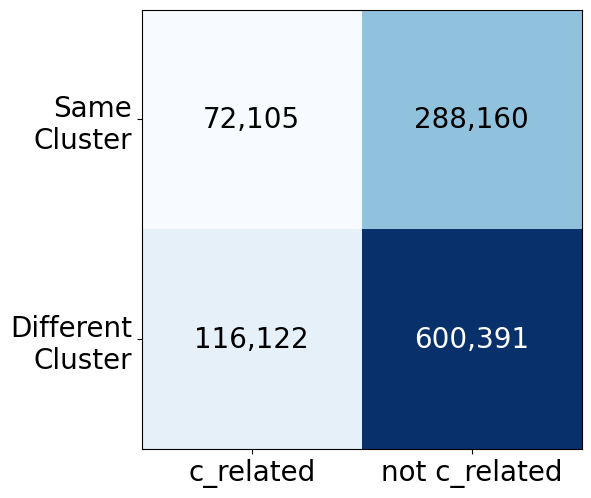

In [24]:
# print matrices for:
category_ind = 3
category = list(data_queries.keys())[category_ind]
i_0 = string_to_num_translator["0:"+category]
print("Category: ",category)

query_ind=1
query = data_queries[category][query_ind]
i_1 = query_ind
print("Query:",query)

embedding_algo_ind =2
embedding_algo = embedding_algos[embedding_algo_ind]
i_2 = embedding_algo_ind
print("Embedding: ",embedding_algo.__module__.split(".")[-1] + "__" + embedding_algo.__name__)

clustering_algo_ind = 3
no_noise0__noise_cluster1 = 1
suffix_noise=""
if clustering_algo_ind < len(clustering_algos):
    clustering_algo = clustering_algos[clustering_algo_ind]
    i_3 = clustering_algo_ind
else:
    clustering_algo_noise_ind = (clustering_algo_ind -len(clustering_algos))//2
    clustering_algo = clustering_algos_noise[clustering_algo_noise_ind]
    i_3 = len(clustering_algos)+2*clustering_algo_noise_ind+no_noise0__noise_cluster1
    if no_noise0__noise_cluster1==1:
        suffix_noise="noise cluster"
    else:
        suffix_noise="without nosie"
print("Clustering: ", clustering_algo.__name__, suffix_noise)

print(i_0,i_1,i_2,i_3)
cm = pair_confusion_matrices[i_0,i_1,i_2,i_3,:,:]

import matplotlib.pyplot as plt

class_labels_true = ['c_related', 'not c_related']
class_labels_pred = ['Same\nCluster', 'Different\nCluster']


# Create the plot
plt.figure(figsize=(6, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

# Add title and labels
#plt.title(query)

# Add ticks and labels for the axes
tick_marks = np.arange(2)
plt.xticks(tick_marks, class_labels_true)
plt.yticks(tick_marks, class_labels_pred)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.gca().grid(False)
# Add annotations (numbers in the matrix cells)
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(int(cm[i, j]), ',d'),
             ha="center", va="center",fontsize=20,
             color="white" if cm[i, j] > thresh else "black")

# Add a colorbar (optional)
#plt.colorbar()

# Show the plot
plt.tight_layout()
plt.savefig(f"pair_conf_matr/E{i_2}_C{clustering_algo.__name__[:5]}{suffix_noise[:5]}_{get_query_key(category,query)}.png", dpi=300, bbox_inches='tight')
plt.show()
